In [31]:
import pandas as pd
import pycountry

# 1. Load the two pieces
music_df = pd.read_csv('country_music_scores.csv')
happiness_df = pd.read_csv('world_happiness_2024.csv', sep=None, engine='python')

# 2. Fix Country Names (US -> United States)
def get_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

music_df['Country_Name'] = music_df['Country_Code'].apply(get_name)

# 3. Merge them
# Find the happiness country column automatically
happ_col = [c for c in happiness_df.columns if 'country' in c.lower()][0]

final_df = pd.merge(
    music_df, 
    happiness_df, 
    left_on='Country_Name', 
    right_on=happ_col,
    how='inner'
)

# 4. SAVE IT
final_df.to_csv('final_project_dataset.csv', index=False)

print("SUCCESS!")
print(f"Created 'final_project_dataset.csv' with {len(final_df)} rows.")

SUCCESS!
Created 'final_project_dataset.csv' with 95 rows.


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Set the visual style for all plots
sns.set(style="whitegrid")

filename = 'final_project_dataset.csv'

try:
    final_df = pd.read_csv(filename)
    print(f"Successfully loaded {len(final_df)} countries.")
    
    # Music Sentiment
    final_df['Avg_Music_Sentiment'] = pd.to_numeric(final_df['Avg_Music_Sentiment'], errors='coerce')
    
    # Identify Happiness Column dynamically
    happiness_col = 'Ladder score' 
    if happiness_col not in final_df.columns:
        for col in final_df.columns:
            if 'ladder' in col.lower() or 'score' in col.lower():
                happiness_col = col
                break
    
    # Happiness Column
    if final_df[happiness_col].dtype == 'object':
         final_df[happiness_col] = final_df[happiness_col].str.replace(',', '.')
    final_df[happiness_col] = pd.to_numeric(final_df[happiness_col], errors='coerce')
    
    # Drop rows with missing values
    final_df = final_df.dropna(subset=['Avg_Music_Sentiment', happiness_col])
    
    print(f"Using Target Variable: '{happiness_col}'")
    print(f"Data ready for analysis. Rows remaining: {len(final_df)}")

except FileNotFoundError:
    print(f"ERROR: Could not find '{filename}'. Check the file name or path.")

Successfully loaded 95 countries.
Using Target Variable: 'Ladder score'
Data ready for analysis. Rows remaining: 95


In [33]:
# Median happiness score
median_happiness = final_df[happiness_col].median()

# New category column based on the median
final_df['Happiness_Category'] = final_df[happiness_col].apply(
    lambda x: 'High Happiness' if x >= median_happiness else 'Low Happiness'
)

print(f"Median Happiness Score: {median_happiness}")
print("New column 'Happiness_Category' created.")
print(final_df[['Country', happiness_col, 'Happiness_Category']].head())

Median Happiness Score: 6.0598
New column 'Happiness_Category' created.
       Country  Ladder score Happiness_Category
0  Philippines        6.0476      Low Happiness
1    Sri Lanka        3.8981      Low Happiness
2  New Zealand        7.0292     High Happiness
3      Georgia        5.1847      Low Happiness
4     Pakistan        4.6567      Low Happiness


## Data Overview

This section provides a summary of the final dataset used for exploratory
data analysis, including its size, structure, and missing values.


In [34]:
print("Number of observations (countries):", final_df.shape[0])
print("Number of variables:", final_df.shape[1])
print("\nColumn names:")
print(final_df.columns.tolist())

print("\nMissing value ratio:")
final_df.isna().mean().sort_values(ascending=False)


Number of observations (countries): 95
Number of variables: 14

Column names:
['Country_Code', 'Avg_Music_Sentiment', 'Country_Name', 'Ranking', 'Country', 'Regional indicator', 'Ladder score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Happiness_Category']

Missing value ratio:


Country_Code                    0.0
Avg_Music_Sentiment             0.0
Country_Name                    0.0
Ranking                         0.0
Country                         0.0
Regional indicator              0.0
Ladder score                    0.0
GDP per capita                  0.0
Social support                  0.0
Healthy life expectancy         0.0
Freedom to make life choices    0.0
Generosity                      0.0
Perceptions of corruption       0.0
Happiness_Category              0.0
dtype: float64

In [35]:
final_df[['Avg_Music_Sentiment', happiness_col]].describe()

,Avg_Music_Sentiment,Ladder score
count,95.000000,95.000000
mean,0.034015,5.915891
std,0.029320,1.041073
min,-0.012662,2.706500
25%,0.016180,5.342750
50%,0.028881,6.059800
75%,0.041073,6.698250
max,0.162485,7.740700


## Distribution of Music Sentiment

This section examines the distribution of average music sentiment scores
across countries before conducting relational and group-based analyses.


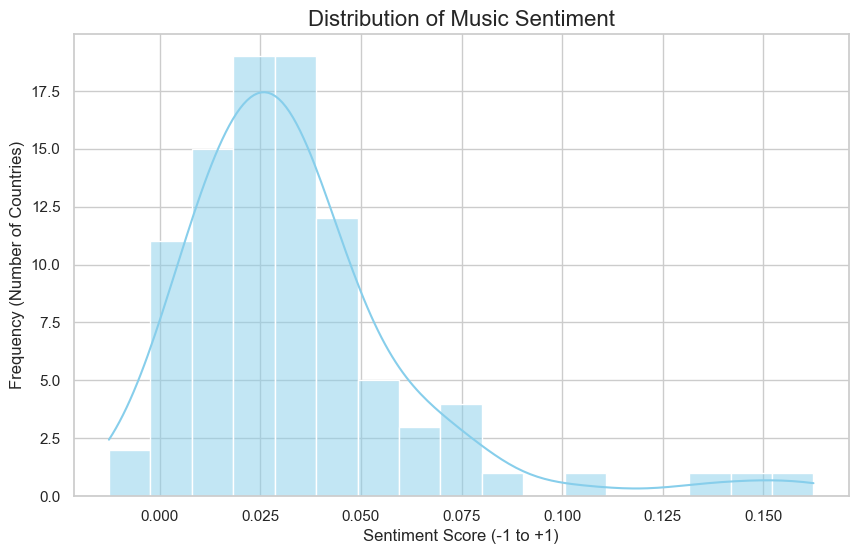

In [36]:
# Set the figure size for a single large plot
plt.figure(figsize=(10, 6))

# Create the Histogram
sns.histplot(final_df['Avg_Music_Sentiment'], kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribution of Music Sentiment', fontsize=16)
plt.xlabel('Sentiment Score (-1 to +1)', fontsize=12)
plt.ylabel('Frequency (Number of Countries)', fontsize=12)

# Display the plot
plt.show()

**Observation:**  
The distribution of music sentiment scores is centered near zero with moderate
variability. The shape suggests potential deviations from normality, motivating
formal normality tests prior to selecting appropriate statistical methods.


## Distribution of National Happiness

This section examines the distribution of the national happiness scores across
countries to understand variability and detect possible skewness/outliers.


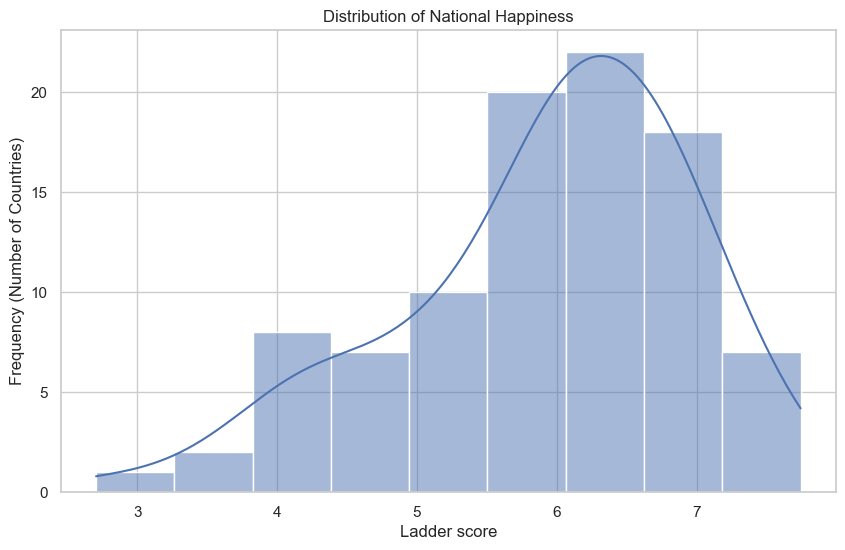

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(final_df[happiness_col], kde=True)
plt.title("Distribution of National Happiness")
plt.xlabel(happiness_col)
plt.ylabel("Frequency (Number of Countries)")
plt.show()


**Observation:**  
The distribution of national happiness scores is unimodal and approximately
bell-shaped, with most countries clustered between scores of around 5 and 7.
A slight left skew is visible, driven by a smaller number of countries with
very low happiness scores, while extreme high-end outliers are limited.
Overall variability is moderate, but deviations from perfect normality are
present, motivating formal normality checks before selecting appropriate
statistical tests.


## Relationship Between Music Sentiment and National Happiness

This section explores the relationship between average music sentiment
and national happiness scores using a scatter plot with a fitted
regression line to visually assess potential associations.


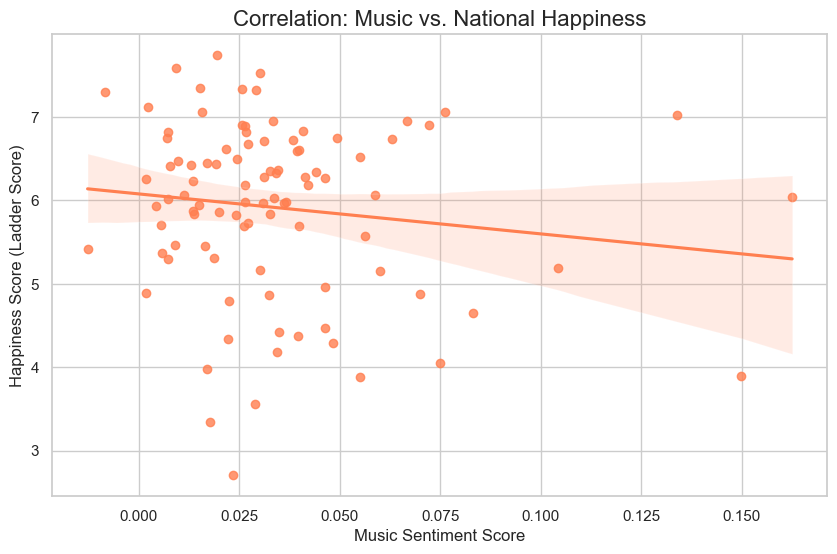

In [38]:
# Set the figure size for a single large plot
plt.figure(figsize=(10, 6))

# Create the Scatter Plot with Regression Line
sns.regplot(data=final_df, x='Avg_Music_Sentiment', y=happiness_col, color='coral')

# Add titles and labels
plt.title('Correlation: Music vs. National Happiness', fontsize=16)
plt.xlabel('Music Sentiment Score', fontsize=12)
plt.ylabel('Happiness Score (Ladder Score)', fontsize=12)

# Display the plot
plt.show()

**Observation:**  
The scatter plot shows substantial dispersion with no strong linear trend.
While a slight slope is visible, the relationship appears weak, suggesting
that any association between music sentiment and national happiness may be
small and requires formal statistical testing to evaluate significance.


## Hypothesis 1: Association Between Music Sentiment and National Happiness

H₀ (Null Hypothesis):  
There is no association between average music sentiment and national happiness.

H₁ (Alternative Hypothesis):  
There is an association between average music sentiment and national happiness.

Significance level: α = 0.05


In [39]:
p_sent = stats.shapiro(final_df['Avg_Music_Sentiment'])[1]
p_happy = stats.shapiro(final_df[happiness_col])[1]

print("Shapiro p (Sentiment):", p_sent)
print("Shapiro p (Happiness):", p_happy)

use_pearson = (p_sent > 0.05) and (p_happy > 0.05)

if use_pearson:
    corr_coef, p_val_corr = stats.pearsonr(final_df['Avg_Music_Sentiment'], final_df[happiness_col])
    test_name = "Pearson"
else:
    corr_coef, p_val_corr = stats.spearmanr(final_df['Avg_Music_Sentiment'], final_df[happiness_col])
    test_name = "Spearman"


Shapiro p (Sentiment): 2.2338148005386493e-09
Shapiro p (Happiness): 0.0017342714830691488


### Interpretation

Normality tests indicate that both average music sentiment and national happiness
scores deviate significantly from a normal distribution (Shapiro–Wilk p < 0.05).
Therefore, a Spearman rank correlation was used to assess the association between
the two variables.

The Spearman correlation analysis yields a p-value greater than 0.05, indicating
that we fail to reject the null hypothesis. This suggests that there is no
statistically significant monotonic association between music sentiment and
national happiness in the observed data.

In addition, the estimated correlation coefficient is small in magnitude,
suggesting that even if a relationship exists, its practical effect is likely
weak. This null result may reflect high variability across countries, limitations
of sentiment analysis applied to music data, or the influence of unobserved
socioeconomic and cultural factors that play a larger role in shaping national
happiness.


## Grouping Countries by Happiness Level

To compare music sentiment between countries with different happiness levels,
countries are divided into two groups based on the median happiness score.

Using the median ensures balanced group sizes and avoids sensitivity to extreme values.
This grouping enables a comparative hypothesis test between high- and low-happiness countries.


In [40]:
final_df['Happiness_Category'].value_counts()

Happiness_Category
High Happiness    48
Low Happiness     47
Name: count, dtype: int64

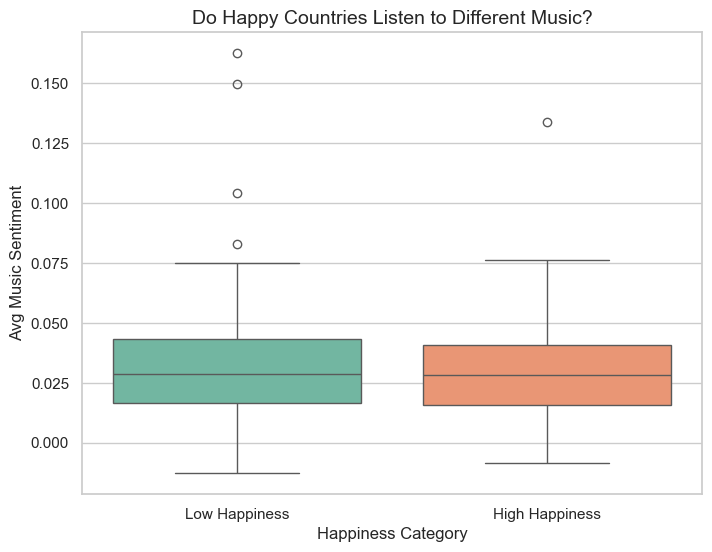

In [41]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    x='Happiness_Category', 
    y='Avg_Music_Sentiment', 
    data=final_df, 
    palette="Set2", 
    hue='Happiness_Category', 
    legend=False
)

plt.title('Do Happy Countries Listen to Different Music?', fontsize=14)
plt.xlabel('Happiness Category')
plt.ylabel('Avg Music Sentiment')
plt.show()

**Observation:**  
The boxplot suggests that the distribution of average music sentiment is broadly similar
between high- and low-happiness countries, with substantial overlap. While the median
sentiment appears slightly higher in one group, the visual difference alone is not
sufficient to draw conclusions, motivating a formal statistical test.


In [42]:
q1 = final_df[happiness_col].quantile(0.25)
q3 = final_df[happiness_col].quantile(0.75)

low_q = final_df[final_df[happiness_col] <= q1]['Avg_Music_Sentiment']
high_q = final_df[final_df[happiness_col] >= q3]['Avg_Music_Sentiment']

u_stat_q, p_q = stats.mannwhitneyu(high_q, low_q, alternative='two-sided')
print("Quartile Mann–Whitney U:", u_stat_q, "p-value:", p_q)


Quartile Mann–Whitney U: 233.0 p-value: 0.2611101618127958


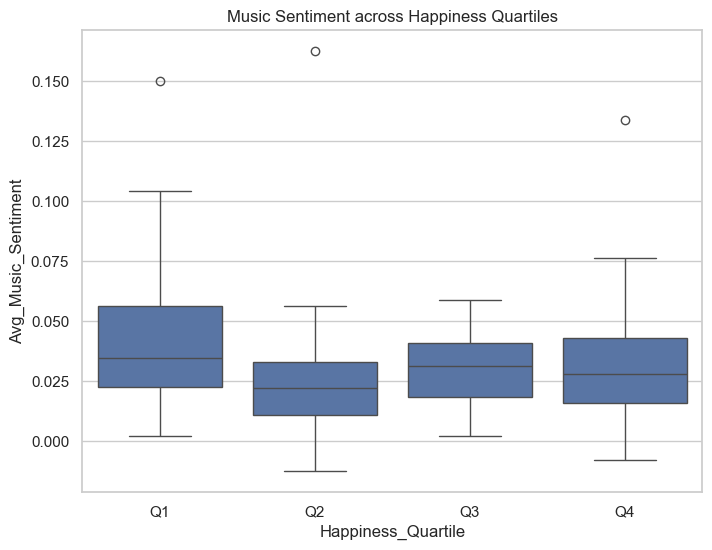

In [43]:
tmp = final_df.copy()
tmp['Happiness_Quartile'] = pd.qcut(tmp[happiness_col], 4, labels=["Q1","Q2","Q3","Q4"])

plt.figure(figsize=(8,6))
sns.boxplot(data=tmp, x='Happiness_Quartile', y='Avg_Music_Sentiment')
plt.title("Music Sentiment across Happiness Quartiles")
plt.show()


## Hypothesis Test 2: Difference in Music Sentiment Between Happiness Groups

H₀ (Null Hypothesis):  
The distribution of average music sentiment is the same for high- and low-happiness countries.

H₁ (Alternative Hypothesis):  
The distribution of average music sentiment differs between the two groups.

Significance level: α = 0.05


In [44]:
high_happiness = final_df[final_df['Happiness_Category'] == 'High Happiness']['Avg_Music_Sentiment']
low_happiness  = final_df[final_df['Happiness_Category'] == 'Low Happiness']['Avg_Music_Sentiment']

p_high = stats.shapiro(high_happiness)[1]
p_low  = stats.shapiro(low_happiness)[1]

print("Shapiro High p:", p_high)
print("Shapiro Low p:", p_low)

u_stat, p_value = stats.mannwhitneyu(high_happiness, low_happiness, alternative='two-sided')
print("Mann–Whitney U:", u_stat)
print("p-value:", p_value)


Shapiro High p: 0.0001634055173813633
Shapiro Low p: 1.5547290843925915e-06
Mann–Whitney U: 1113.0
p-value: 0.9140489950309714


To test whether music sentiment differs between high- and low-happiness countries,
a non-parametric Mann–Whitney U test is used, as normality assumptions are violated.


### Interpretation

Normality tests indicate that average music sentiment is non-normally distributed
in both high- and low-happiness groups (Shapiro–Wilk p < 0.05); therefore, a
Mann–Whitney U test was used.

The test yields a p-value of 0.914, which is well above the significance level
(α = 0.05). Thus, we fail to reject the null hypothesis, indicating no
statistically significant difference in music sentiment between high- and
low-happiness countries.

The large p-value suggests that the sentiment distributions of the two groups
are highly similar. This result implies that music sentiment alone is unlikely
to meaningfully differentiate national happiness levels, with broader
socioeconomic and cultural factors likely playing a more influential role.
